In [1]:
import datetime

%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pianoq.simulations.mplc_sim.mplc_modes import get_speckle_modes_conf, get_spots_modes_conf
from pianoq.simulations.mplc_sim.mplc_utils import get_lens_mask_conf, get_lens_mask
from pianoq.simulations.mplc_sim.mplc_sim import MPLCSim
from pianoq.simulations.mplc_sim.mplc_modes2 import gen_input_spots_array

can't use vimba camera
can't import TimeTagger
could not import ThorlabsRotatingServoMotor


# Run MPLC

## parameters

In [3]:
# All in m

dist_after_plane = 87e-3*np.ones(10)
dist_after_plane[4] = 138e-3
# Lense in plane 9 between 7 and 11. Allow phases freedom in plane 11 since I measure intensity
active_planes = np.array([True] * 11)
active_planes[7:10] = False  # [7,8,9] which is planes 8,9,10 (one before and after lens)

N_modes = 16  # for photons 1 and 2, 4 spots to speckle and 4 speckles to spots (4+4)*2 = 16
# All in mm
conf = {'wavelength': 810e-9,  # m
        'dist_after_plane': dist_after_plane,  # m
        'active_planes': active_planes,  # bool
        'N_iterations': 15,
        'Nx': 140,  # Number of grid points x-axis
        'Ny': 360,  # Number of grid points y-axis
        'dx': 12.5e-6,  # m - SLM pixel sizes
        'dy': 12.5e-6,  # m
        'max_k_constraint': 0.15,  # Ohad: better than 0.1 or 0.2, but not very fine-tuned
        'N_modes': N_modes,
        'min_log_level': 2,
        'size_factor': 3,  # assumed to be odd. Have physical larger grid than the actual SLM planes
        'use_mask_offset': True,
        }


# Spot params
waist_in = 80e-6
waist_out = 80e-6
D_between_modes_in = 300e-6
D_between_modes_out = 360e-6
dim=5
# modes are ordered like this: lab/mplc/mask_utils.py
which_modes = np.array([7, 17, 9, 19,
                        32, 42, 34, 44])

mplc = MPLCSim(conf=conf)
input_spots, _, _ = gen_input_spots_array(waist=waist_in, D_between_modes=D_between_modes_in, XX=mplc.XX, YY=mplc.YY, dim=dim)
input_spots = input_spots[which_modes]
output_spots, _, _ = gen_input_spots_array(waist=waist_out, D_between_modes=D_between_modes_out, XX=mplc.XX, YY=mplc.YY, dim=dim)
output_spots = output_spots[which_modes]

# This here is for different diffusers for the two photons.
upper_active_slice = np.index_exp[360+30:360+180-15, 160:260]
upper_active_slice = None 
upper_speckles = get_speckle_modes_conf(conf, N_modes=8, sig=0.48e-3, diffuser_pix_size=0.15e-3, active_slice=upper_active_slice, y_displace=72)
lower_active_slice = np.index_exp[360+180+15:360+180+150, 160:260]
lower_active_slice = None 
lower_speckles = get_speckle_modes_conf(conf, N_modes=8, sig=0.48e-3, diffuser_pix_size=0.15e-3, active_slice=lower_active_slice, y_displace=-72)

# lower number spots are for lower half of SLM speckles
input_modes = np.concatenate([input_spots, lower_speckles[:4], upper_speckles[:4]])
output_modes = np.concatenate([lower_speckles[4:], upper_speckles[4:], output_spots])

# For same diffusers for both photons we need to generate the same speckles + correct flips between upper and lower halves 

Visualize input and output modes

In [ ]:
plt.close('all')
i = 8
im_in = input_modes[i]
im_out = output_modes[i]
fig, axes = plt.subplots(1, 2)
axes[0].imshow((np.abs(im_in)**2)[mplc.res.active_slice])
axes[1].imshow((np.abs(im_out)**2)[mplc.res.active_slice])

Run MPLC 

In [5]:
mplc.set_modes(input_modes, output_modes)
lens_mask = get_lens_mask(Nx=conf['Nx'], Ny=conf['Ny']//2, dx=conf['dx'], dy=conf['dy'], wl=mplc.wavelength, f=2*87e-3)
mplc.res.masks[8][mplc.res.active_slice] = np.vstack((lens_mask, lens_mask))
mplc.find_phases(fix_initial_phases=False)  # ovelaping speckles, can't use fix_initial_phases 

100%|██████████| 15/15 [04:43<00:00, 18.88s/it]


In [6]:
mplc.res._calc_fidelity()
mplc.res.fidelity

0.08263213822520549

In [ ]:
fig, axes = plt.subplots(2, 5)
for i, ax in enumerate(axes.flat):
    # ax.imshow(np.angle(res.masks[i][360:720, 140:280]), cmap='gray')
    ax.imshow(np.angle(mplc.res.masks[i][360:720, 140:280]), cmap='gray')

In [ ]:
mplc.res.show_overlap()

In [9]:
timestamp = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
path = f"C:\\temp\\mplcs\\{timestamp}_diffuser.mplc"
masks_path = fr"G:\My Drive\Projects\MPLC\results\simulations\masks\{timestamp}_diffuser.masks"
# mplc.res.saveto(path, smaller=True)
mplc.res.save_masks(masks_path)

In [ ]:
mplc.res.show_all()
plt.show()

# FOO 

In [ ]:
%matplotlib notebook
from pianoq.simulations.mplc_sim.mplc_sim_result import MPLCSimResult
res = MPLCSimResult()
res.loadfrom("C:\\temp\\speckle_speckle1.mplc")

In [ ]:
%matplotlib notebook
res = mplc.res

In [ ]:
%matplotlib notebook
res.show_all(0)

import matplotlib.pyplot as plt
plt.plot([1,2,3], [2,4,5])

In [23]:
from pianoq.simulations.mplc_sim.mplc_sim_result import MPLCMasks
m = MPLCMasks()
m.loadfrom(r"C:\temp\mplcs\2024_09_03_14_14_18_diffuser.masks")

fig, axes = plt.subplots(2, 5)
for i, ax in enumerate(axes.flat):
    ax.imshow(np.angle(m.masks[i]), cmap='gray')

# Use new function to do the WFM, and then just display some metrics

In [2]:
from pianoq.simulations.mplc_sim.create_wfm_masks import create_WFM_diffuser_masks
mplc = create_WFM_diffuser_masks()

100%|██████████| 30/30 [11:22<00:00, 22.75s/it]


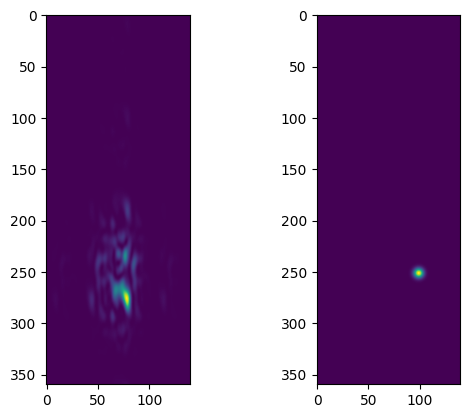

In [9]:
plt.close('all')
i = 8
im_in = mplc.input_modes[i]
im_out = mplc.output_modes[i]
fig, axes = plt.subplots(1, 2)
axes[0].imshow((np.abs(im_in)**2)[mplc.res.active_slice])
axes[1].imshow((np.abs(im_out)**2)[mplc.res.active_slice])
plt.show()

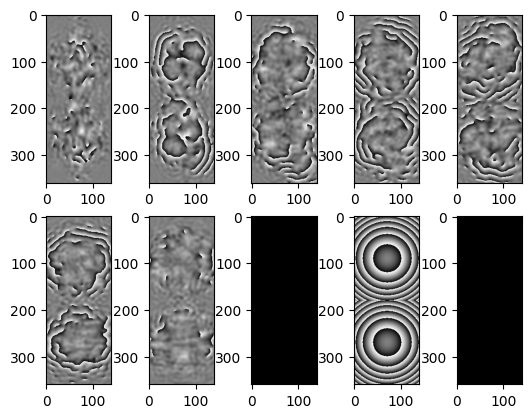

In [4]:
fig, axes = plt.subplots(2, 5)
for i, ax in enumerate(axes.flat):
    # ax.imshow(np.angle(res.masks[i][360:720, 140:280]), cmap='gray')
    ax.imshow(np.angle(mplc.res.masks[i][360:720, 140:280]), cmap='gray')

C:\code\pianoq\pianoq\simulations\mplc_sim\mplc_sim_result.py:95: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


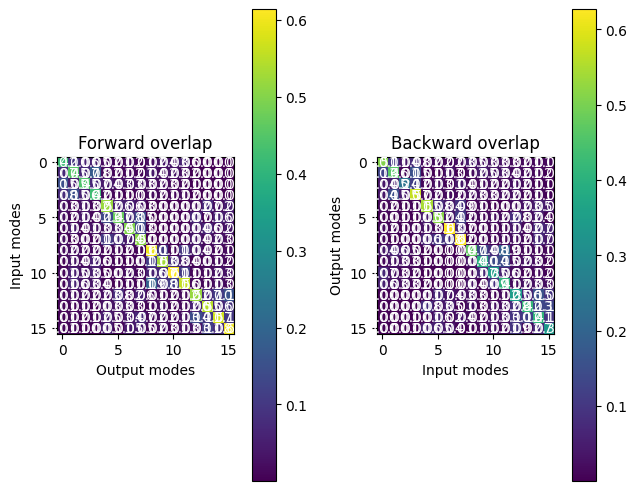

In [5]:
mplc.res.show_overlap()

C:\code\pianoq\pianoq\simulations\mplc_sim\mplc_sim_result.py:156: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


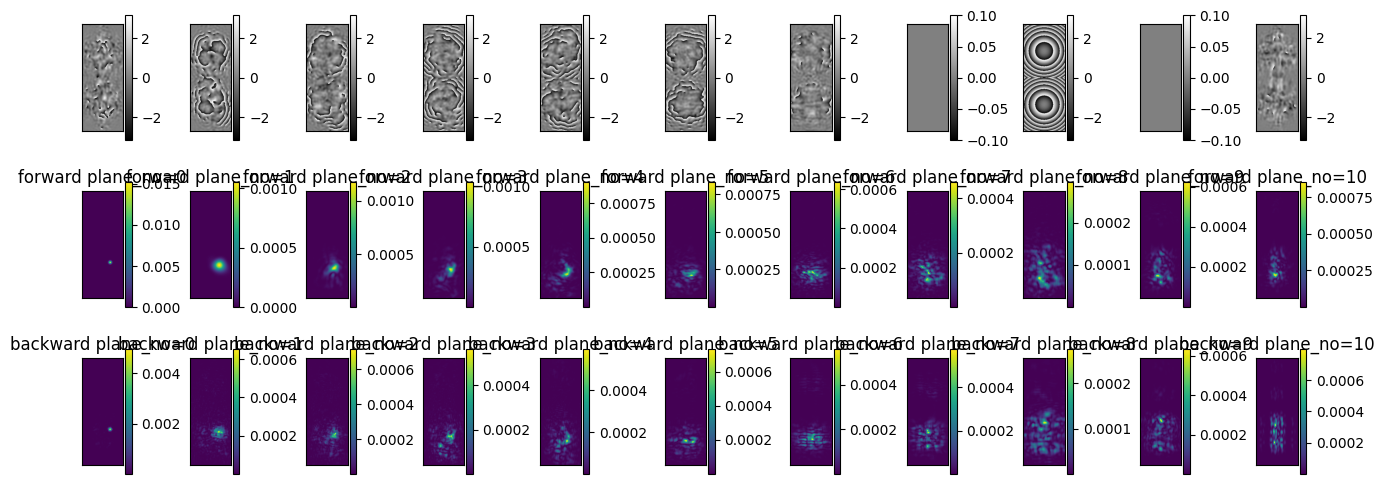

In [6]:
mplc.res.show_all()